In [47]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [49]:
config = {
        'batch_size': 64,
        'num_epochs': 100,
        'output_dir': 'mlp_results_opt',
        'use_augmentation': True  #Cambiar a False si no se quiere augmentation
    }

print(f"\nConfiguración:")
for key, value in config.items():
    print(f"   {key}: {value}")


Configuración:
   batch_size: 64
   num_epochs: 100
   output_dir: mlp_results_opt
   use_augmentation: True


## MLP SIN FEATURE EXTRACTOR

In [50]:
def load_raw_pixel_data(prefix='covid19_raw_opt'):
    """Carga datos de píxeles crudos optimizados"""
    print(f"\nCargando datos RAW")
    
    X_train = np.load(f'{prefix}_X_train.npy')
    X_val = np.load(f'{prefix}_X_val.npy')
    X_test = np.load(f'{prefix}_X_test.npy')
    y_train = np.load(f'{prefix}_y_train.npy')
    y_val = np.load(f'{prefix}_y_val.npy')
    y_test = np.load(f'{prefix}_y_test.npy')
    
    print(f"   Train: {X_train.shape}")
    print(f"   Val:   {X_val.shape}")
    print(f"   Test:  {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [51]:
X_train_raw, X_val_raw, X_test_raw, y_train_raw, y_val_raw, y_test_raw = \
        load_raw_pixel_data('covid19_raw_opt')


Cargando datos RAW
   Train: (28536, 16384)
   Val:   (6116, 16384)
   Test:  (6116, 16384)


In [52]:
def prepare_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=64):
    """Prepara DataLoaders de PyTorch"""
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    
    y_train_tensor = torch.LongTensor(y_train_encoded)
    y_val_tensor = torch.LongTensor(y_val_encoded)
    y_test_tensor = torch.LongTensor(y_test_encoded)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"\nDataLoaders creados (batch_size={batch_size})")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches:   {len(val_loader)}")
    print(f"   Test batches:  {len(test_loader)}")
    
    return train_loader, val_loader, test_loader, le

In [53]:
class MLP_Shallow(nn.Module):
    """
    Arquitectura Shallow
    """
    def __init__(self, input_size, num_classes):
        super(MLP_Shallow, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(192, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [54]:
class MLP_Medium(nn.Module):
    """
    Arquitectura Medium
    """
    def __init__(self, input_size, num_classes):
        super(MLP_Medium, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [55]:
class MLP_Deep_Regularized(nn.Module):
    """
    Arquitectura Deep 
    """
    def __init__(self, input_size, num_classes):
        super(MLP_Deep_Regularized, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(0.6),
            
            nn.Linear(768, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(192, 96),
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(96, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [56]:
def validate(model, val_loader, criterion, device):
    """Valida el modelo"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / total
    val_acc = correct / total
    
    return val_loss, val_acc

In [57]:
def get_augmented_batch(X_batch, img_size=128, augmentation_probability=0.3):
    """
    Aplica data augmentation on-the-fly durante entrenamiento
    
    Solo para datos RAW (píxeles), no para LBP
    """
    X_aug = X_batch.clone()
    batch_size, features = X_aug.shape
    
    # Verificar que el tamaño es correcto
    if features != img_size * img_size:
        return X_aug  # No augmentar si no es una imagen cuadrada
    
    for i in range(batch_size):
        if np.random.rand() < augmentation_probability:
            # Reshape a imagen
            img = X_aug[i].reshape(img_size, img_size).cpu().numpy()
            
            # Aplicar transformación aleatoria
            aug_type = np.random.choice([
                'rotate', 'flip', 'shift', 'noise', 'brightness'
            ])
            
            if aug_type == 'rotate':
                angle = np.random.uniform(-10, 10)
                M = cv2.getRotationMatrix2D((img_size/2, img_size/2), angle, 1.0)
                img = cv2.warpAffine(img, M, (img_size, img_size), borderMode=cv2.BORDER_REFLECT)
            
            elif aug_type == 'flip':
                img = np.fliplr(img)
            
            elif aug_type == 'shift':
                shift_x = int(np.random.uniform(-5, 5))
                shift_y = int(np.random.uniform(-5, 5))
                M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
                img = cv2.warpAffine(img, M, (img_size, img_size), borderMode=cv2.BORDER_REFLECT)
            
            elif aug_type == 'noise':
                noise = np.random.normal(0, 0.05, img.shape)
                img = img + noise
            
            elif aug_type == 'brightness':
                factor = np.random.uniform(0.9, 1.1)
                img = img * factor
            
            # Volver a aplanar
            X_aug[i] = torch.from_numpy(img.flatten().astype(np.float32))
    
    return X_aug

In [58]:
def train_epoch(model, train_loader, criterion, optimizer, device, 
                         use_augmentation=False, img_size=128):
    """
    Entrena el modelo por una época
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Aplicar augmentation si está habilitado
        if use_augmentation:
            inputs = get_augmented_batch(inputs, img_size, augmentation_probability=0.3)
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


In [59]:
def train_model(model, train_loader, val_loader, num_epochs, device, 
                         model_name, use_augmentation=False, img_size=128):
    """
    Entrena el modelo
    """
    print(f"\nEntrenando {model_name}")
    
    # Criterio con label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # AdamW con weight decay más fuerte
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=0.001,
        weight_decay=1e-4  # Era 1e-5
    )
    
    # Learning rate scheduler: Reduce on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5
    )
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 15
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device,
            use_augmentation, img_size
        )
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_acc)
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print cada 5 épocas
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
                  f"Train: {train_loss:.4f}/{train_acc:.4f} | "
                  f"Val: {val_loss:.4f}/{val_acc:.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping en época {epoch+1}")
            break
    
    training_time = time.time() - start_time
    model.load_state_dict(best_model_state)
    
    print(f"\n✓ Entrenamiento completado en {training_time:.2f}s")
    print(f"  Mejor Val Accuracy: {best_val_acc:.4f}")
    print("="*70)
    
    return model, history, training_time, best_val_acc

In [60]:
def evaluate_model(model, test_loader, device, label_encoder):
    """Evalúa el modelo en el conjunto de test"""
    model.eval()
    all_preds = []
    all_labels = []
    
    inference_times = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = label_encoder.inverse_transform(all_preds)
    all_labels = label_encoder.inverse_transform(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    cm = confusion_matrix(all_labels, all_preds, labels=label_encoder.classes_)
    
    avg_inference_time = np.mean(inference_times) * 1000
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'avg_inference_time_ms': avg_inference_time,
        'predictions': all_preds,
        'true_labels': all_labels
    }
    
    return metrics


In [61]:
def print_metrics(metrics, class_names, model_name):
    """Imprime métricas de forma legible"""
    print(f"\nMétricas de {model_name}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"Inference: {metrics['avg_inference_time_ms']:.2f} ms/batch")
    
    print(f"\nMétricas por clase:")
    print(f"{'Clase':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<25} "
              f"{metrics['precision_per_class'][i]:<12.4f} "
              f"{metrics['recall_per_class'][i]:<12.4f} "
              f"{metrics['f1_per_class'][i]:<12.4f}")
    

In [62]:
def plot_training_history(history, model_name, save_path):
    """Grafica el historial de entrenamiento"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Época', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Época', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Época', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title(f'{model_name} - Learning Rate', fontsize=14, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Gráfica guardada: {save_path}")


def plot_confusion_matrix(cm, class_names, model_name, save_path):
    """Grafica la matriz de confusión"""
    plt.figure(figsize=(10, 8))
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proporción'})
    
    plt.title(f'{model_name} - Matriz de Confusión (Normalizada)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Matriz de confusión guardada: {save_path}")


def plot_comparison_table(results_df, save_path):
    """Crea tabla comparativa de todos los modelos"""
    fig, ax = plt.subplots(figsize=(16, len(results_df) * 0.8))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    for _, row in results_df.iterrows():
        table_data.append([
            row['Modelo'],
            f"{row['Accuracy']:.4f}",
            f"{row['Precision']:.4f}",
            f"{row['Recall']:.4f}",
            f"{row['F1-Score']:.4f}",
            f"{row['Train Time (s)']:.2f}",
            f"{row['Inference (ms)']:.2f}",
            f"{row['Params']:,}"
        ])
    
    columns = ['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
               'Train Time (s)', 'Inference (ms)', 'Parámetros']
    
    table = ax.table(cellText=table_data, colLabels=columns,
                     cellLoc='center', loc='center',
                     colWidths=[0.20, 0.10, 0.10, 0.10, 0.10, 0.12, 0.12, 0.12])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    for i in range(len(columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(len(columns)):
                table[(i, j)].set_facecolor('#F0F0F0')
    
    plt.title('Comparación de Modelos MLP OPTIMIZADOS', fontsize=16, fontweight='bold', pad=20)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Tabla comparativa guardada: {save_path}")

In [63]:
def train_all_architectures(X_train, X_val, X_test, y_train, y_val, y_test,
                                     data_type, batch_size=64, num_epochs=100, 
                                     output_dir='results_opt', use_augmentation=False):
    """
    Entrena todas las arquitecturas OPTIMIZADAS
    """
    print(f"Entrenando modelos MLP - {data_type.upper()}")
    
    output_path = Path(output_dir) / data_type
    output_path.mkdir(parents=True, exist_ok=True)
    
    train_loader, val_loader, test_loader, le = prepare_dataloaders(
        X_train, X_val, X_test, y_train, y_val, y_test, batch_size
    )
    
    input_size = X_train.shape[1]
    num_classes = len(le.classes_)
    class_names = le.classes_
    
    # Determinar img_size para augmentation
    img_size = int(np.sqrt(input_size)) if input_size == 128*128 else 0
    
    print(f"\nConfiguración:")
    print(f"   Input size: {input_size}")
    print(f"   Num classes: {num_classes}")
    print(f"   Classes: {list(class_names)}")
    print(f"   Data augmentation: {'Enabled' if use_augmentation and img_size > 0 else '✗ Disabled'}")
    
    # Definir arquitecturas OPTIMIZADAS
    architectures = {
        f'{data_type}_shallow': MLP_Shallow(input_size, num_classes),
        f'{data_type}_medium': MLP_Medium(input_size, num_classes),
        f'{data_type}_deep_regularized': MLP_Deep_Regularized(input_size, num_classes)
    }
    
    results = []
    
    for model_name, model in architectures.items():
        print(f"Arquitectura: {model_name}")
        
        model = model.to(device)
        
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"   Parámetros entrenables: {num_params:,}")
        
        # Entrenar con optimizaciones
        model, history, train_time, best_val_acc = train_model(
            model, train_loader, val_loader, num_epochs, device, model_name,
            use_augmentation=(use_augmentation and img_size > 0), img_size=img_size
        )
        
        # Evaluar
        metrics = evaluate_model(model, test_loader, device, le)
        
        print_metrics(metrics, class_names, model_name)
        
        # Guardar modelo
        model_path = output_path / f'{model_name}.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'num_classes': num_classes,
            'class_names': list(class_names),
            'label_encoder': le,
            'metrics': metrics,
            'history': history
        }, model_path)
        print(f"\nModelo guardado: {model_path}")
        
        # Visualizaciones
        plot_training_history(history, model_name, 
                            output_path / f'{model_name}_history.png')
        plot_confusion_matrix(metrics['confusion_matrix'], class_names, model_name,
                            output_path / f'{model_name}_confusion.png')
        
        # Guardar resultados
        results.append({
            'Modelo': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Train Time (s)': train_time,
            'Inference (ms)': metrics['avg_inference_time_ms'],
            'Params': num_params,
            'Best Val Acc': best_val_acc
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    csv_path = output_path / 'comparison.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"\nResultados guardados: {csv_path}")
    
    plot_comparison_table(results_df, output_path / 'comparison_table.png')
    
    print(f"RESUMEN - {data_type.upper()}")
    print(results_df.to_string(index=False))
    
    return results_df

In [64]:
results_raw = train_all_architectures(
        X_train_raw, X_val_raw, X_test_raw,
        y_train_raw, y_val_raw, y_test_raw,
        data_type='raw',
        batch_size=config['batch_size'],
        num_epochs=config['num_epochs'],
        output_dir=config['output_dir'],
        use_augmentation=config['use_augmentation']
    )

Entrenando modelos MLP - RAW

DataLoaders creados (batch_size=64)
   Train batches: 446
   Val batches:   96
   Test batches:  96

Configuración:
   Input size: 16384
   Num classes: 4
   Classes: [np.str_('COVID'), np.str_('Lung_Opacity'), np.str_('Normal'), np.str_('Viral Pneumonia')]
   Data augmentation: Enabled
Arquitectura: raw_shallow
   Parámetros entrenables: 6,367,684

Entrenando raw_shallow
Epoch [  5/100] | Train: 0.6861/0.8267 | Val: 0.6478/0.8424 | LR: 0.001000
Epoch [ 10/100] | Train: 0.6190/0.8657 | Val: 0.6170/0.8658 | LR: 0.001000
Epoch [ 15/100] | Train: 0.5763/0.8938 | Val: 0.5977/0.8723 | LR: 0.001000
Epoch [ 20/100] | Train: 0.5460/0.9152 | Val: 0.5894/0.8818 | LR: 0.001000
Epoch [ 25/100] | Train: 0.5286/0.9241 | Val: 0.5838/0.8865 | LR: 0.001000
Epoch [ 30/100] | Train: 0.5107/0.9338 | Val: 0.5798/0.8873 | LR: 0.001000
Epoch [ 35/100] | Train: 0.4861/0.9483 | Val: 0.5705/0.8911 | LR: 0.000500
Epoch [ 40/100] | Train: 0.4723/0.9553 | Val: 0.5672/0.8939 | LR: 0.00

## Visualización de Mapas de Calor

In [65]:
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [66]:
def compute_integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    """
    Calcula Integrated Gradients para MLPs
    
    Paper: "Axiomatic Attribution for Deep Networks" (Sundararajan et al., 2017)
    
    Args:
        model: Modelo MLP entrenado
        input_tensor: Tensor de entrada (1, features)
        target_class: Clase objetivo
        baseline: Baseline (default: ceros)
        steps: Número de pasos de interpolación (50 es suficiente)
    
    Returns:
        Gradientes integrados (numpy array)
    """
    model.eval()
    
    # Usar ceros como baseline si no se especifica
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    # Generar interpolaciones lineales entre baseline y entrada
    alphas = torch.linspace(0, 1, steps).to(input_tensor.device)
    
    integrated_grads = torch.zeros_like(input_tensor)
    
    # Calcular gradientes para cada interpolación
    for alpha in alphas:
        interpolated = baseline + alpha * (input_tensor - baseline)
        interpolated.requires_grad = True
        
        output = model(interpolated)
        model.zero_grad()
        output[0, target_class].backward()
        
        integrated_grads += interpolated.grad
    
    # Promedio y multiplicar por diferencia (fórmula de IG)
    integrated_grads = integrated_grads / steps
    integrated_grads = integrated_grads * (input_tensor - baseline)
    
    return integrated_grads.squeeze().cpu().numpy()

In [67]:
def smooth_heatmap(heatmap, sigma=3):
    """
    Aplica suavizado Gaussiano para apariencia profesional estilo Grad-CAM
    
    Args:
        heatmap: Mapa de calor (H, W)
        sigma: Nivel de suavizado (2=ligero, 3=medio, 4=fuerte)
    
    Returns:
        Heatmap suavizado
    """
    return gaussian_filter(heatmap, sigma=sigma)


def enhance_heatmap(heatmap, percentile=85):
    """
    Realza el contraste enfocándose en regiones importantes
    
    Args:
        heatmap: Mapa de calor
        percentile: Percentil para threshold (85 = top 15%)
    
    Returns:
        Heatmap con contraste mejorado
    """
    threshold = np.percentile(heatmap, percentile)
    enhanced = heatmap.copy()
    
    # Atenuar valores por debajo del threshold
    enhanced[enhanced < threshold] = enhanced[enhanced < threshold] * 0.3
    
    return enhanced


def create_gradcam_style_overlay(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Crea overlay estilo Grad-CAM (más profesional que overlay simple)
    
    Args:
        img: Imagen original (H, W) grayscale
        heatmap: Mapa de calor (H, W)
        alpha: Transparencia del heatmap (0.5 = 50%)
        colormap: Colormap de OpenCV (JET es el estándar)
    
    Returns:
        Imagen RGB con overlay
    """
    # Convertir imagen a RGB
    if len(img.shape) == 2:
        img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = (img * 255).astype(np.uint8)
    
    # Normalizar heatmap a [0, 1]
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    # Aplicar colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_norm), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Crear overlay con alpha blending
    overlay = cv2.addWeighted(img_rgb, 1-alpha, heatmap_colored, alpha, 0)
    
    return overlay

In [68]:
def visualize_mlp_heatmaps(model, X_test, y_test, class_names, img_size=128,
                          n_samples=5, output_dir='mlp_heatmaps',
                          use_smoothing=True, sigma=3, percentile=85):
    """
    Visualiza mapas de calor para MLP con estilo Grad-CAM
    
    Args:
        model: Modelo MLP entrenado
        X_test: Datos de test (N, features)
        y_test: Labels de test (N,)
        class_names: Lista de nombres de clases
        img_size: Tamaño de imagen (asume cuadrada, default=128)
        n_samples: Número de muestras por clase (default=5)
        output_dir: Directorio de salida
        use_smoothing: Aplicar suavizado Gaussiano (default=True)
        sigma: Nivel de suavizado (2-4 recomendado, default=3)
        percentile: Percentil para realce de contraste (default=85)
    
    Returns:
        None (guarda imágenes en output_dir)
    """
    print(f"\nGenerando mapas de calor estilo Grad-CAM para MLP...")
    print(f"   Parámetros: smoothing={use_smoothing}, sigma={sigma}, percentile={percentile}")
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Codificar labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_test)
    
    # Para cada clase
    for class_idx, class_name in enumerate(class_names):
        print(f"\n   Procesando clase: {class_name}")
        
        # Obtener índices de esta clase
        class_indices = np.where(y_encoded == class_idx)[0]
        
        if len(class_indices) == 0:
            print(f"    No hay muestras de {class_name}")
            continue
        
        # Seleccionar muestras aleatorias
        selected_indices = np.random.choice(
            class_indices, 
            min(n_samples, len(class_indices)), 
            replace=False
        )
        
        # Crear figura con GridSpec (colorbar a la derecha)
        fig = plt.figure(figsize=(n_samples * 3 + 1.5, 9))
        gs = gridspec.GridSpec(
            3, n_samples + 1,
            width_ratios=[1]*n_samples + [0.05],
            hspace=0.3, wspace=0.2
        )
        
        im = None
        
        for idx, sample_idx in enumerate(selected_indices):
            # Preparar input
            input_data = torch.FloatTensor(X_test[sample_idx:sample_idx+1]).to(device)
            
            # Calcular Integrated Gradients
            gradients = compute_integrated_gradients(model, input_data, class_idx)
            
            # Reshape a imagen
            img_original = X_test[sample_idx].reshape(img_size, img_size)
            gradient_map = np.abs(gradients).reshape(img_size, img_size)
            
            # PIPELINE DE MEJORAS VISUALES
            # Paso 1: Suavizado Gaussiano (opcional pero recomendado)
            if use_smoothing:
                gradient_map_smooth = smooth_heatmap(gradient_map, sigma=sigma)
            else:
                gradient_map_smooth = gradient_map
            
            # Paso 2: Realce de contraste
            gradient_map_enhanced = enhance_heatmap(gradient_map_smooth, percentile=percentile)
            
            # Paso 3: Normalizar a [0, 1]
            heatmap = (gradient_map_enhanced - gradient_map_enhanced.min()) / \
                     (gradient_map_enhanced.max() - gradient_map_enhanced.min() + 1e-8)
            
            # Paso 4: Crear overlay estilo Grad-CAM
            img_display = (img_original - img_original.min()) / \
                         (img_original.max() - img_original.min() + 1e-8)
            overlay = create_gradcam_style_overlay(img_display, heatmap, alpha=0.5)
            
            # VISUALIZACIÓN
            # Fila 1: Imagen original
            ax1 = fig.add_subplot(gs[0, idx])
            ax1.imshow(img_display, cmap='gray')
            ax1.set_title(f'Original {idx+1}', fontsize=10, fontweight='bold')
            ax1.axis('off')
            
            # Fila 2: Heatmap
            ax2 = fig.add_subplot(gs[1, idx])
            im = ax2.imshow(heatmap, cmap='jet')
            ax2.set_title('Importance Map', fontsize=10, fontweight='bold')
            ax2.axis('off')
            
            # Fila 3: Overlay
            ax3 = fig.add_subplot(gs[2, idx])
            ax3.imshow(overlay)
            ax3.set_title('Overlay', fontsize=10, fontweight='bold')
            ax3.axis('off')
        
        # Colorbar a la derecha (ocupa las 3 filas)
        if im is not None:
            cbar_ax = fig.add_subplot(gs[:, -1])
            cbar = plt.colorbar(im, cax=cbar_ax)
            cbar.set_label('Importancia', rotation=270, labelpad=20, fontsize=11)
            cbar.ax.tick_params(labelsize=9)
        
        # Título
        plt.suptitle(
            f'MLP - Integrated Gradients (Grad-CAM Style) - Clase: {class_name}',
            fontsize=14, fontweight='bold', y=0.98
        )
        
        # Mostrar
        plt.show()

In [69]:
def load_trained_mlp_model(model_path):
    """
    Carga un modelo MLP entrenado desde archivo .pth
    
    Args:
        model_path: Ruta al archivo .pth del modelo
    
    Returns:
        model: Modelo cargado en eval mode
        checkpoint: Diccionario con metadata del modelo
    """
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    input_size = checkpoint['input_size']
    num_classes = checkpoint['num_classes']
    
    model_name = Path(model_path).stem
    
    # Detectar arquitectura basándose en el nombre
    if 'shallow' in model_name:
        model = MLP_Shallow(input_size, num_classes)
    elif 'medium' in model_name:
        model = MLP_Medium(input_size, num_classes)
    elif 'deep' in model_name or 'regularized' in model_name:
        model = MLP_Deep_Regularized(input_size, num_classes)
    else:
        raise ValueError(f"No se pudo detectar la arquitectura del modelo: {model_name}")
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"Modelo cargado: {model_name}")
    print(f"   Input size: {input_size}")
    print(f"   Num classes: {num_classes}")
    print(f"   Classes: {checkpoint['class_names']}")
    
    return model, checkpoint

In [70]:
heatmap_config = {
    # Ruta al mejor modelo (ajusta según tus resultados)
    'model_path': 'mlp_results_opt/raw/raw_shallow.pth',  # Cambiar al mejor modelo
    
    # Datos de test
    'data_prefix': 'covid19_raw_opt',
    
    # Directorio de salida
    'output_dir': 'mlp_heatmaps',
    
    # Parámetros de imagen
    'img_size': 128,  # Ajustar si usaste diferente tamaño
    
    # Parámetros de visualización
    'n_samples': 5,              # Muestras por clase
    'use_smoothing': True,       # Suavizado Gaussiano
    'sigma': 3,                  # Nivel de suavizado (2=ligero, 3=medio, 4=fuerte)
    'percentile': 85,            # Percentil para realce (80-90 recomendado)
}

for key, value in heatmap_config.items():
    print(f"   {key}: {value}")

   model_path: mlp_results_opt/raw/raw_shallow.pth
   data_prefix: covid19_raw_opt
   output_dir: mlp_heatmaps
   img_size: 128
   n_samples: 5
   use_smoothing: True
   sigma: 3
   percentile: 85



Cargando modelo entrenado
Modelo cargado: raw_shallow
   Input size: 16384
   Num classes: 4
   Classes: [np.str_('COVID'), np.str_('Lung_Opacity'), np.str_('Normal'), np.str_('Viral Pneumonia')]

Cargando datos de test
   Test set: (6116, 16384)

Generando mapas de calor

Generando mapas de calor estilo Grad-CAM para MLP...
   Parámetros: smoothing=True, sigma=3, percentile=85

   Procesando clase: COVID


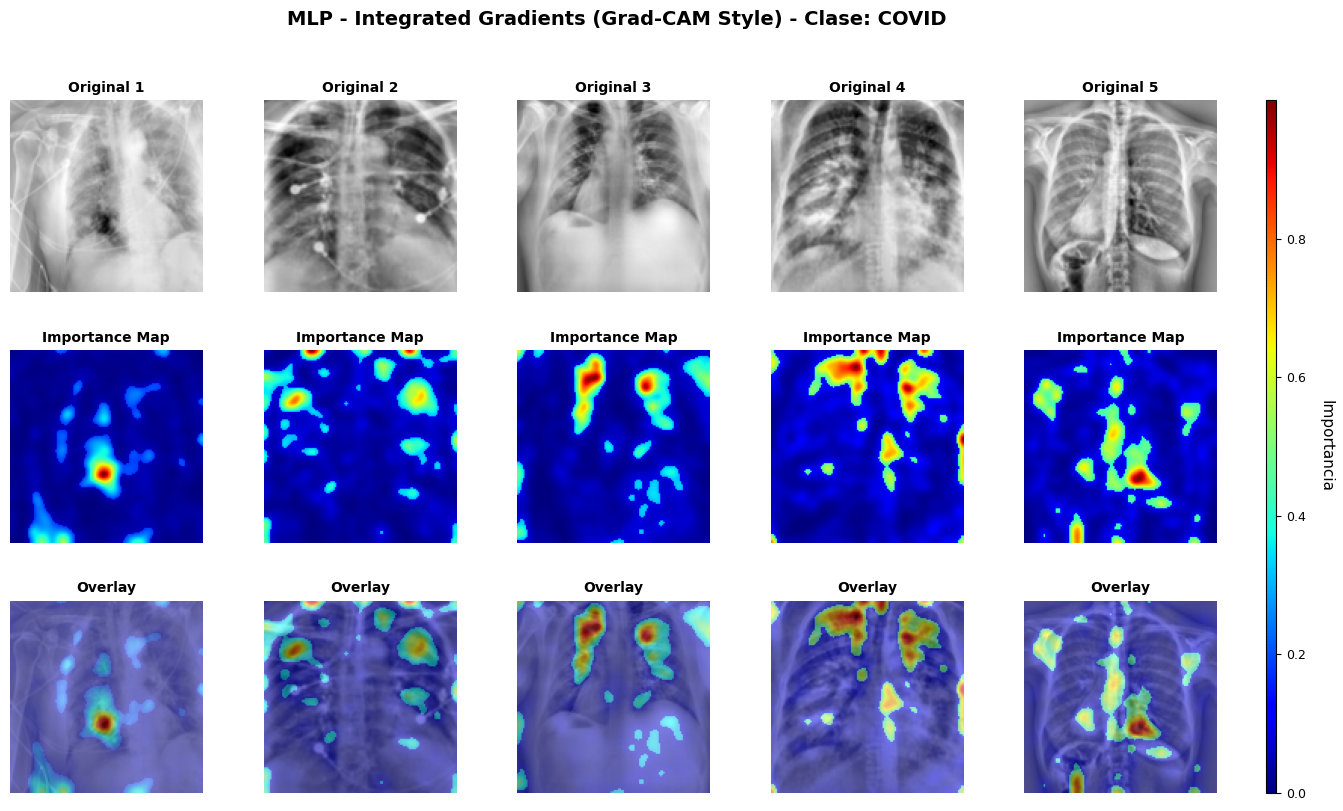


   Procesando clase: Lung_Opacity


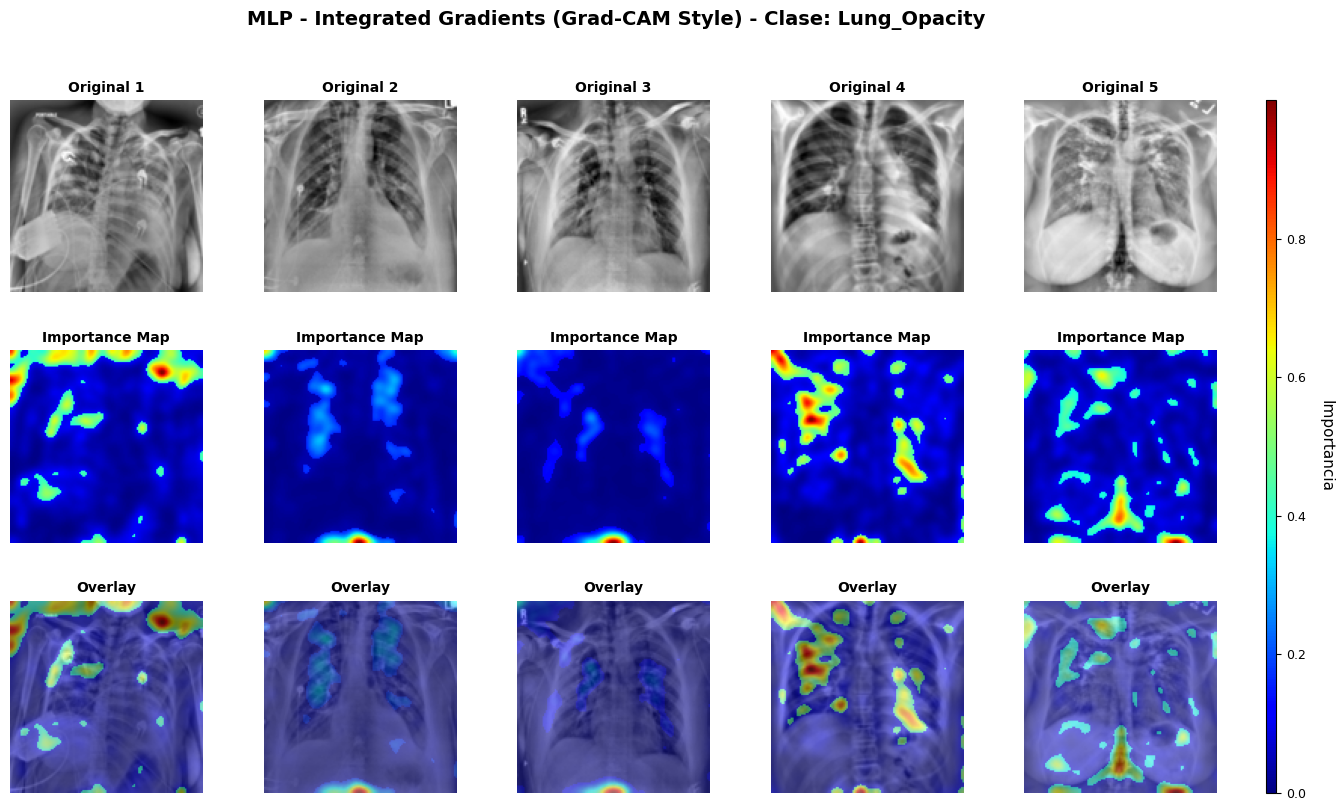


   Procesando clase: Normal


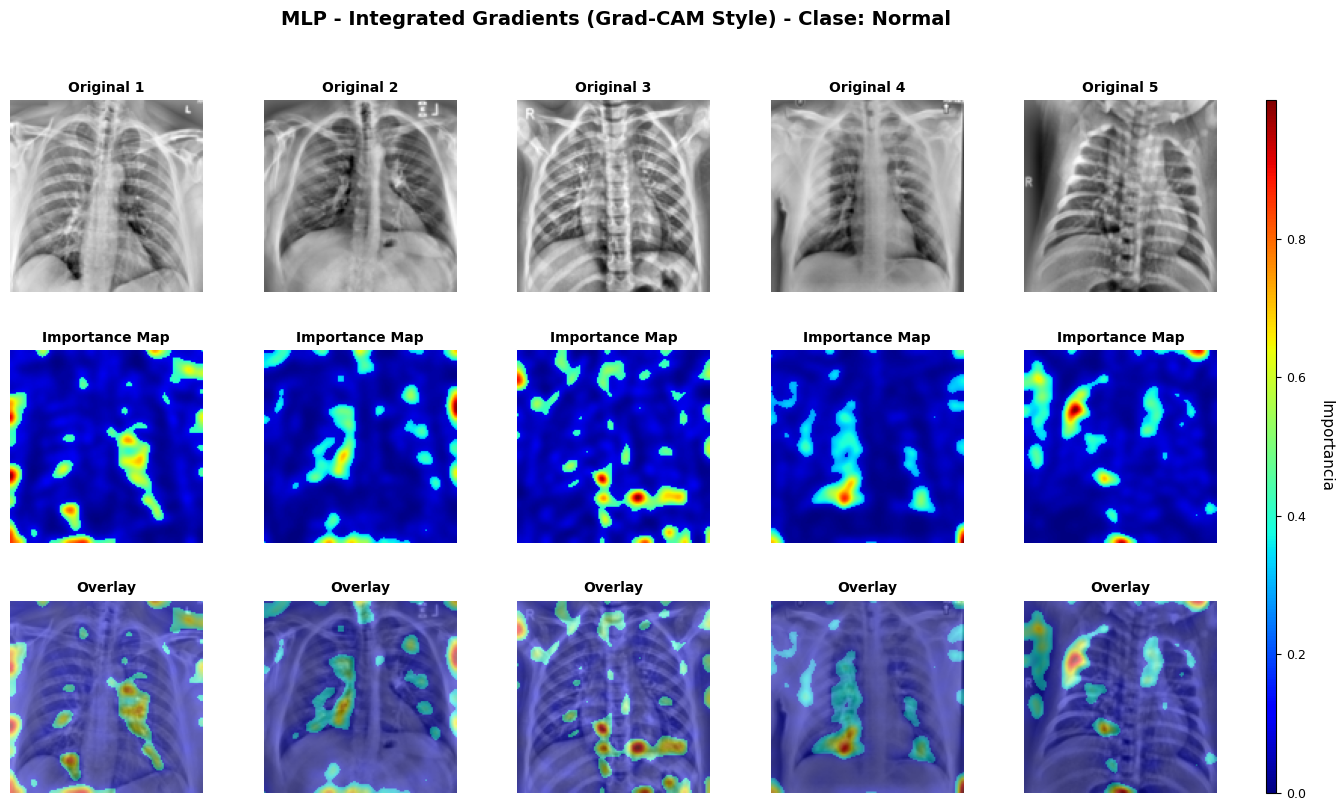


   Procesando clase: Viral Pneumonia


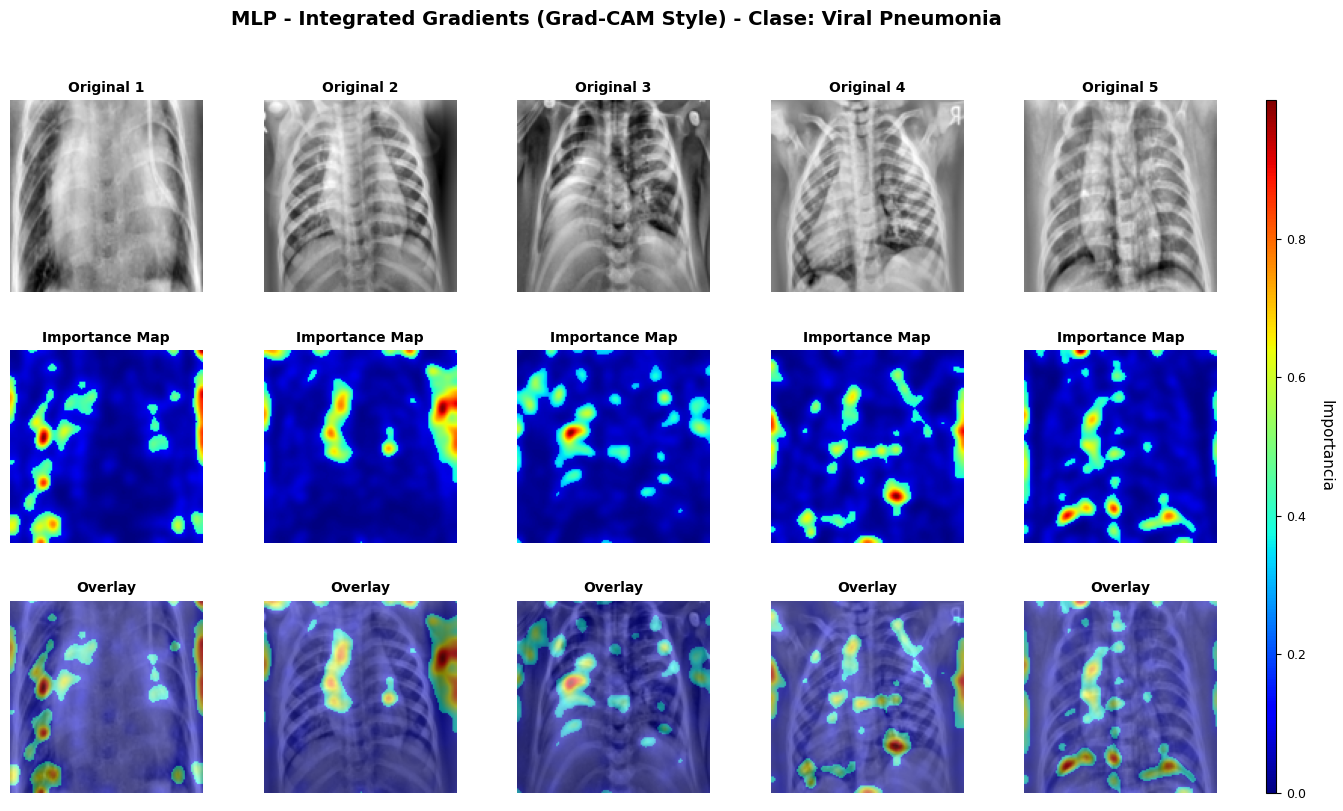

In [71]:
print("\nCargando modelo entrenado")
model_heatmap, checkpoint = load_trained_mlp_model(heatmap_config['model_path'])

print("\nCargando datos de test")
X_test_heatmap = np.load(f"{heatmap_config['data_prefix']}_X_test.npy")
y_test_heatmap = np.load(f"{heatmap_config['data_prefix']}_y_test.npy")
print(f"   Test set: {X_test_heatmap.shape}")

print("\nGenerando mapas de calor")
visualize_mlp_heatmaps(
    model=model_heatmap,
    X_test=X_test_heatmap,
    y_test=y_test_heatmap,
    class_names=checkpoint['class_names'],
    img_size=heatmap_config['img_size'],
    n_samples=heatmap_config['n_samples'],
    output_dir=heatmap_config['output_dir'],
    use_smoothing=heatmap_config['use_smoothing'],
    sigma=heatmap_config['sigma'],
    percentile=heatmap_config['percentile']
)